# PCA Approach
This file goes through the PCA approach to achieving better performance.

We will also experiment with benefits of treating this data as binary classification and merging results for having the disease (1,2,3,4) vs. not having the disease (0), since it is very unbalanced in terms of samples with each distribution. It may also be beneficial to attempt some approaches that have the goal of maintaing class balances.

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

In [20]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def run_models(X_train, X_test, y_train, y_test):
    rfmodel = RandomForestClassifier(n_estimators=100)
    gbmodel = GradientBoostingClassifier(n_estimators=100)
    abmodel = AdaBoostClassifier(n_estimators=100)
    etmodel = ExtraTreesClassifier(n_estimators=100)
    lrmodel = LogisticRegression()
    svcmodel = SVC()
    dtmodel = DecisionTreeClassifier()
    vcmodel = VotingClassifier(estimators=[('rf', rfmodel), ('gb', gbmodel), ('ab', abmodel), ('et', etmodel), ('lr', lrmodel), ('svc', svcmodel), ('dt', dtmodel)], voting='hard')
    bcmodel = BaggingClassifier(n_estimators=100)

    models = [rfmodel, gbmodel, abmodel, etmodel, lrmodel, svcmodel, dtmodel, vcmodel, bcmodel]
    acc_scores = []
    recall_scores = []
    precision_scores = []
    f1_scores = []
    train_acc = []

    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc_scores.append(accuracy_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred, average='micro'))
        precision_scores.append(precision_score(y_test, y_pred, average = 'micro'))
        f1_scores.append(f1_score(y_test, y_pred, average='micro'))
        train_acc.append(accuracy_score(y_train, model.predict(X_train)))
        
    return pd.DataFrame({'Model': ['Random Forest', 'Gradient Boosting', 'AdaBoost', 'Extra Trees', 'Logistic Regression', 'SVC', 'Decision Tree', 
                                    'Voting Classifier', 'Bagging Classifier'], 'Accuracy': acc_scores, 'Recall': recall_scores, 'Precision': precision_scores, 'F1': f1_scores, 'Training Accuracies': train_acc})

In [21]:
# Load the dataset
df = pd.read_csv("cleaned_heart_disease.csv")

df_bin = df.copy()
# Convert target variable into binary classification (0 = no disease, 1 = has disease)
df_bin['target'] = df_bin['target'].apply(lambda x: 1 if x > 0 else 0)

target
3    329
0    329
2    329
1    329
4    329
Name: count, dtype: int64


c:\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


,Model,Accuracy,Recall,Precision,F1,Training Accuracies
0,Random Forest,0.478261,0.478261,0.478261,0.478261,1.000000
1,Gradient Boosting,0.483696,0.483696,0.483696,0.483696,0.940426
2,AdaBoost,0.461957,0.461957,0.461957,0.461957,0.543465
3,Extra Trees,0.532609,0.532609,0.532609,0.532609,1.000000
4,Logistic Regression,0.472826,0.472826,0.472826,0.472826,0.536778
5,SVC,0.516304,0.516304,0.516304,0.516304,0.748328
6,Decision Tree,0.391304,0.391304,0.391304,0.391304,1.000000
7,Voting Classifier,0.516304,0.516304,0.516304,0.516304,0.966565
8,Bagging Classifier,0.472826,0.472826,0.472826,0.472826,1.000000


Accuracy: 0.47282608695652173
Confusion Matrix:
 [[58 10  3  8  3]
 [ 9 18  9 11  6]
 [ 1  6  4  8  3]
 [ 1  6  6  3  5]
 [ 0  0  1  1  4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.71      0.77        82
           1       0.45      0.34      0.39        53
           2       0.17      0.18      0.18        22
           3       0.10      0.14      0.12        21
           4       0.19      0.67      0.30         6

    accuracy                           0.47       184
   macro avg       0.35      0.41      0.35       184
weighted avg       0.54      0.47      0.50       184



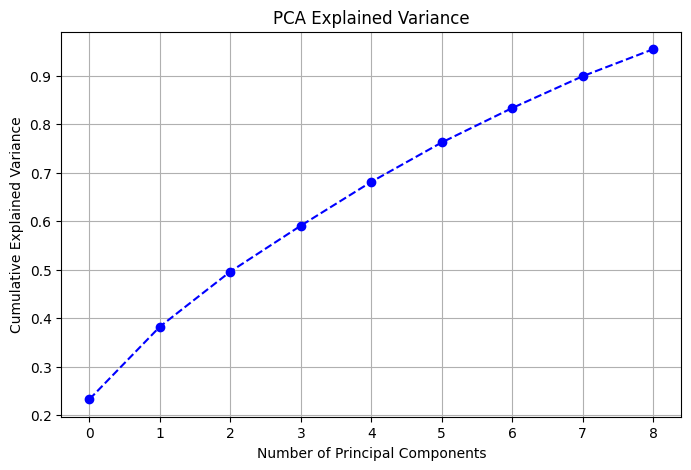

In [22]:
# Split features and target
X = df.drop(columns=['target'])
y = df['target']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance using SMOTE (Synthetic Minority Oversampling Technique)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(y_train_resampled.value_counts())

display(run_models(X_train_resampled, X_test, y_train_resampled, y_test))

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot explained variance ratio of PCA components
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()


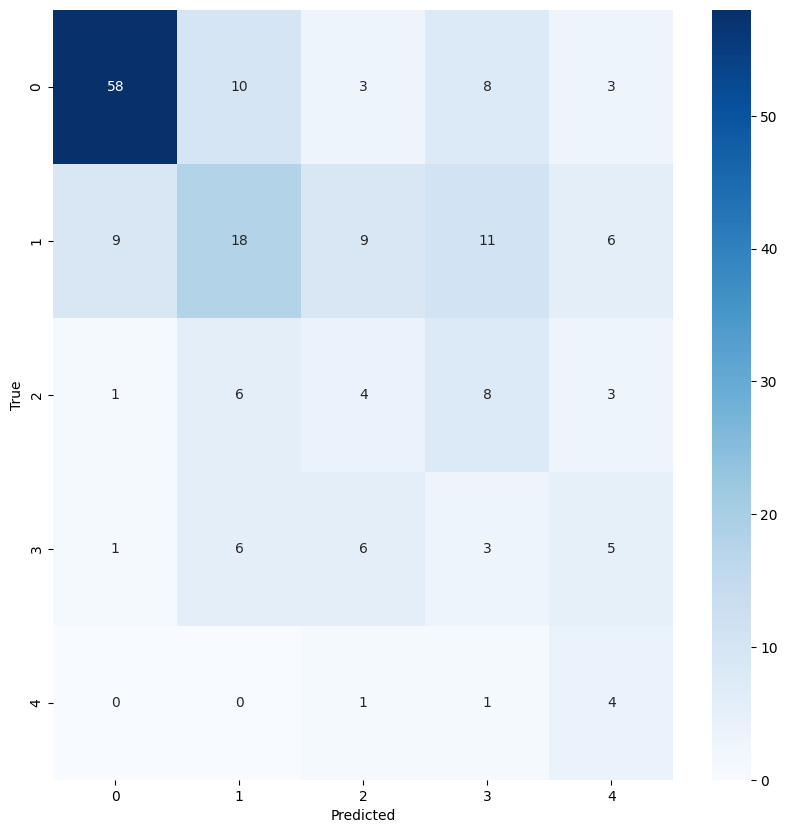

In [23]:
conf_m = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_m, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

c:\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


,Model,Accuracy,Recall,Precision,F1,Training Accuracies
0,Random Forest,0.798913,0.798913,0.798913,0.798913,1.000000
1,Gradient Boosting,0.826087,0.826087,0.826087,0.826087,0.914005
2,AdaBoost,0.793478,0.793478,0.793478,0.793478,0.883292
3,Extra Trees,0.793478,0.793478,0.793478,0.793478,1.000000
4,Logistic Regression,0.798913,0.798913,0.798913,0.798913,0.803440
5,SVC,0.831522,0.831522,0.831522,0.831522,0.855037
6,Decision Tree,0.760870,0.760870,0.760870,0.760870,1.000000
7,Voting Classifier,0.809783,0.809783,0.809783,0.809783,0.937346
8,Bagging Classifier,0.788043,0.788043,0.788043,0.788043,1.000000


Accuracy: 0.7989130434782609
Confusion Matrix:
 [[64 18]
 [19 83]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.78      0.78        82
           1       0.82      0.81      0.82       102

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.80      0.80      0.80       184



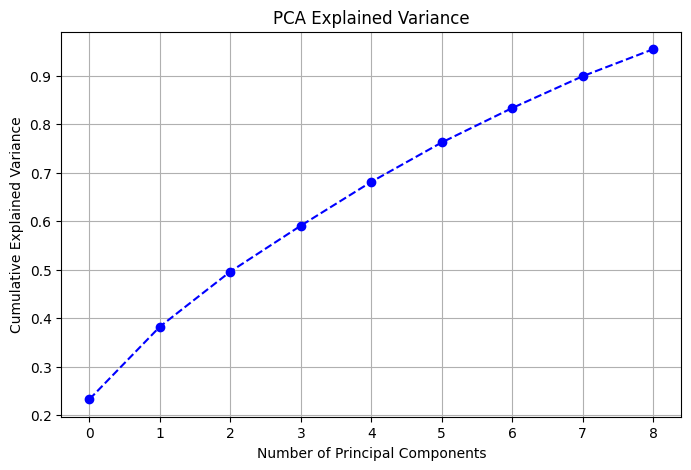

In [26]:
# Split features and target
X = df_bin.drop(columns=['target'])
y = df_bin['target']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance using SMOTE (Synthetic Minority Oversampling Technique)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

display(run_models(X_train_resampled, X_test, y_train_resampled, y_test))

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot explained variance ratio of PCA components
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()


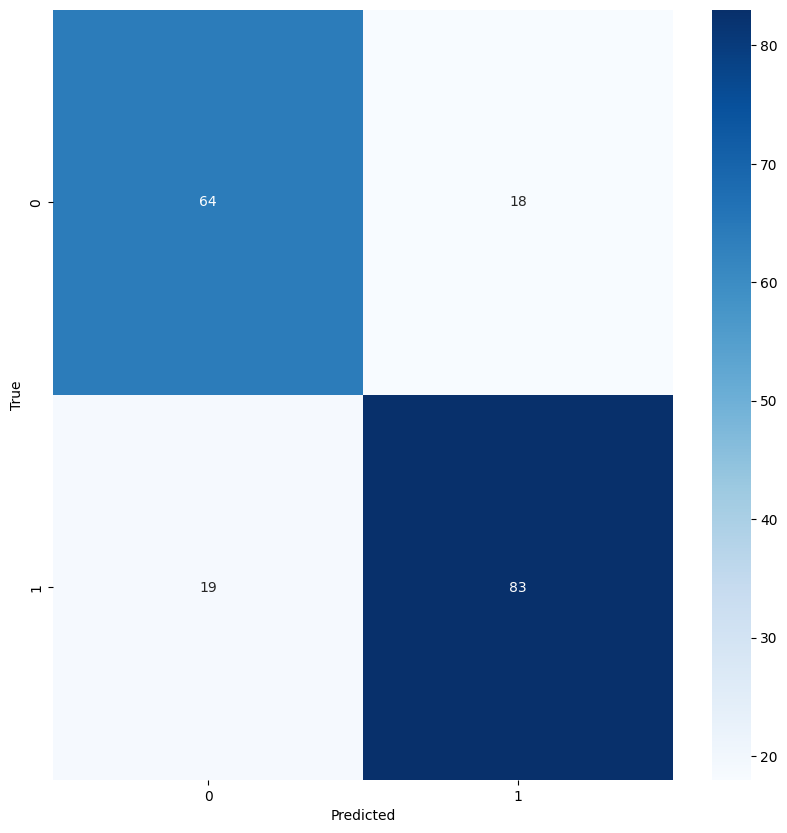

In [25]:
conf_m = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_m, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()